In [5]:
import yfinance as yf

import numpy as np
import pandas as pd

In [6]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random 

plt.style.use(['science', 'retro', 'grid'])

import sys
import cvxopt as opt
sys.path.insert(0, os.path.abspath('../../src/rl/dir_vec/'))
sys.path.insert(4, os.path.abspath('../../src/rl/gaussian/'))
sys.path.insert(1, os.path.abspath('../../src/rl/environments/'))
sys.path.insert(1, os.path.abspath('../../src/rl/environments/base'))
sys.path.insert(2, os.path.abspath('../../src/mpt/efficient_frontier/'))
sys.path.insert(3, os.path.abspath('../../src/mpt/utils'))

In [9]:
import importlib
importlib.reload(sys.modules['EfficientFrontier'])
importlib.reload(sys.modules['MarketFactory'])
importlib.reload(sys.modules['HistoricalMarketEnv'])
importlib.reload(sys.modules['HarnessVec'])
importlib.reload(sys.modules['ParallelRunnerVec'])
importlib.reload(sys.modules['DirichletPolicyVec'])
importlib.reload(sys.modules['HistoricalMarketEnv'])
importlib.reload(sys.modules['HistoricalHarnessVec'])
importlib.reload(sys.modules['GaussianPolicy'])
importlib.reload(sys.modules['HistoricalGaussianHarness'])

<module 'HistoricalGaussianHarness' from '/Users/michael/UCL/Disertation/porfolio-optimisation/src/rl/gaussian/HistoricalGaussianHarness.py'>

In [10]:
from GenerativeMarketEnv import GenerativeMarketEnv
from DirichletPolicyVec import DirichletPolicyVec
from HarnessVec import HarnessVec
from ParallelRunnerVec import ParallelRunnerVec
from EfficientFrontier import EfficientFrontier
from MarketFactory import MarketFactory
from HistoricalMarketEnv import HistoricalMarketEnv
from HistoricalHarnessVec import HistoricalHarnessVec
from GaussianPolicy import GaussianPolicy
from HistoricalGaussianHarness import HistoricalGaussianHarness

In [11]:
# stocks to consider 
stocks = ['AAPL' ,'ADBE' ,'ADI' ,'ADP' ,'ADSK' ,'AEP' ,'ALGN' ,'ALXN' ,'AMAT' ,'AMD' ,'AMGN' ,'AMZN' ,'ANSS' ,'ASML' ,'ATVI'
 ,'AVGO' ,'BIDU' ,'BIIB' ,'BKNG' ,'CDNS' ,'CDW' ,'CERN' ,'CHKP' ,'CHTR' ,'CMCSA' ,'COST' ,'CPRT' ,'CSCO' ,'CSX' ,'CTAS'
 ,'CTSH' ,'DLTR' ,'DOCU' ,'DXCM' ,'EA' ,'EBAY' ,'EXC' ,'FAST' ,'FB' ,'FISV' ,'GILD' ,'GOOG' ,'GOOGL'
 ,'IDXX' ,'ILMN' ,'INCY' ,'INTC' ,'INTU' ,'ISRG' ,'JD' ,'KDP' ,'KHC' ,'KLAC' ,'LRCX' ,'LULU' ,'MAR' ,'MCHP' ,'MDLZ'
 ,'MELI' ,'MNST' ,'MRNA' ,'MRVL' ,'MSFT' ,'MTCH' ,'MU' ,'MXIM' ,'NFLX' ,'NTES' ,'NVDA' ,'NXPI' ,'OKTA' ,'ORLY' ,'PAYX'
 ,'PCAR' ,'PDD' ,'PEP'  ,'PYPL' ,'QCOM' ,'REGN' ,'ROST' ,'SBUX' ,'SGEN' ,'SIRI' ,'SNPS' ,'SPLK' ,'SWKS' ,'TCOM'
 ,'TEAM' ,'TMUS' ,'TSLA' ,'TXN' ,'VRSK' ,'VRSN' ,'VRTX' ,'WBA' ,'WDAY' ,'XEL' ,'XLNX']

# Dirichlet Policy - Returns

# Stable Environment - Returns

In [108]:
random.shuffle(stocks)
sampled_stocks_10 = stocks[:25]

dparams = {
    'n_assets': len(sampled_stocks_10),
    'α': 4,
    'α_end': 4,
    'start_ep': 400000, 
    'α_decay_steps': 400000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

gparams = {
    'n_assets': len(sampled_stocks_10),
    'α_μ': 0.1,
    'α_σ': 1e-9,
    'γ': 0.1,
    'eps': 1000
}

factory = MarketFactory(sampled_stocks_10, "2017-01-01", "2019-01-01", type='historical')
market1 = factory.create_market()

market2 = factory.create_market()

gp = GaussianPolicy(*list(gparams.values())[:-1])
gh = HistoricalGaussianHarness(market1, gp)

dp = DirichletPolicyVec(*list(dparams.values())[:-1])
dh = HistoricalHarnessVec(market2, dp)


for i in range(12):
    
    gp.reset()
    gh.train(num_episodes=dparams['eps'])
    gh.historical_test()
    
    dp.reset()
    dh.train(num_episodes=dparams['eps'])
    dh.historical_test()

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed


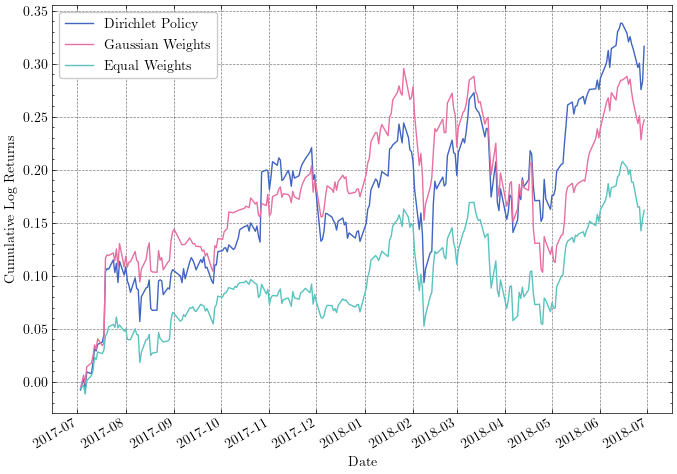

In [109]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# plt.figure(figsize=(8, 6), dpi=100)

ax.plot(dh.test_dates, np.cumsum(dh.historical_policy_returns), label='Dirichlet Policy')
ax.plot(gh.test_dates, np.cumsum(gh.historical_policy_returns), label='Gaussian Weights')
ax.plot(gh.test_dates, np.cumsum(gh.historical_eq_weight_returns), label='Equal Weights')

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.


# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

plt.ylabel('Cumulative Log Returns')
plt.xlabel('Date')
# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.legend()

plt.savefig('stable_env_7')

In [98]:
gp.θ_μ

array([4.00323685, 1.09931452, 0.3823434 , 0.25841411, 1.06167237,
       1.04650363, 0.73926745, 0.70166465, 2.41290565, 0.44991479,
       0.65859049, 1.39671126, 0.63633114, 0.56877905, 0.99390542,
       1.03137688, 1.97248272, 0.33018932, 1.3987234 , 1.04814808,
       0.8662054 , 0.61271856, 0.88778187, 1.22756576, 0.44641594])

In [99]:
dp.act(dp.calc_an())

array([[5.88238526e-02, 1.10959726e-04, 1.13241862e-02, 1.79566705e-06,
        1.40730673e-01, 3.82599154e-03, 8.40251135e-04, 3.66345129e-02,
        2.50948105e-01, 1.28629210e-06, 1.15422282e-02, 6.94313756e-02,
        4.35827966e-05, 5.16060965e-03, 5.14406816e-03, 1.19995921e-02,
        3.21244323e-01, 1.09574117e-06, 6.90317621e-02, 2.61140996e-10,
        9.25892755e-05, 3.89077573e-06, 2.80252778e-04, 2.77250351e-03,
        1.05109222e-05]])

In [100]:
market1.returns_df.columns

Index(['ALGN', 'ASML', 'BKNG', 'DOCU', 'NFLX', 'AVGO', 'QCOM', 'DLTR', 'MELI',
       'AAPL', 'EXC', 'ANSS', 'PDD', 'SGEN', 'MNST', 'FB', 'ATVI', 'BIIB',
       'TEAM', 'ADI', 'TMUS', 'AMD', 'MAR', 'CDNS', 'CHTR'],
      dtype='object')

In [104]:
market1.returns_df.columns

Index(['MRVL', 'DOCU', 'MTCH', 'EBAY', 'MU', 'GILD', 'LRCX', 'FISV', 'ADSK',
       'TEAM', 'AEP', 'CDW', 'ORLY', 'MCHP', 'CDNS', 'WDAY', 'BIDU', 'TSLA',
       'SBUX', 'TXN', 'CHKP', 'KDP', 'LULU', 'OKTA', 'DLTR'],
      dtype='object')

In [110]:
market1.returns_df.columns

Index(['INCY', 'OKTA', 'CSX', 'TCOM', 'WDAY', 'ALGN', 'ORLY', 'ANSS', 'CDW',
       'PCAR', 'DOCU', 'VRTX', 'ATVI', 'AMD', 'CTAS', 'CERN', 'LRCX', 'CMCSA',
       'ASML', 'KHC', 'SNPS', 'EA', 'KLAC', 'ALXN', 'NXPI'],
      dtype='object')

In [107]:
market1.returns_df.columns

Index(['NFLX', 'AVGO', 'NTES', 'VRSN', 'AMAT', 'PYPL', 'INTU', 'PDD', 'KLAC',
       'BIDU', 'CDNS', 'BIIB', 'SWKS', 'IDXX', 'TXN', 'BKNG', 'XEL', 'MTCH',
       'SBUX', 'MRVL', 'AMD', 'PEP', 'CHKP', 'MRNA', 'COST'],
      dtype='object')

In [549]:
assets = "['SNPS', 'AMGN', 'SIRI', 'DXCM', 'ADI', 'GOOG', 'NXPI', 'MTCH', 'XLNX',       'CPRT', 'ADBE', 'KDP', 'CSX', 'DOCU', 'SGEN', 'TMUS', 'CDW', 'AVGO',       'AAPL', 'ILMN', 'VRSN', 'LULU', 'INCY', 'WBA', 'TCOM']"

In [550]:
assets.replace('\'', '')

'[SNPS, AMGN, SIRI, DXCM, ADI, GOOG, NXPI, MTCH, XLNX,       CPRT, ADBE, KDP, CSX, DOCU, SGEN, TMUS, CDW, AVGO,       AAPL, ILMN, VRSN, LULU, INCY, WBA, TCOM]'

In [557]:
market1.returns_df.columns

Index(['ADP', 'EBAY', 'ROST', 'PEP', 'ALXN', 'MRNA', 'MRVL', 'DLTR', 'MU',
       'BIIB', 'NFLX', 'AVGO', 'TCOM', 'CPRT', 'JD', 'AMZN', 'ADBE', 'KHC',
       'IDXX', 'ISRG', 'TXN', 'DOCU', 'MAR', 'NVDA', 'ANSS'],
      dtype='object')

In [558]:
assets = "['ADP', 'EBAY', 'ROST', 'PEP', 'ALXN', 'MRNA', 'MRVL', 'DLTR', 'MU',       'BIIB', 'NFLX', 'AVGO', 'TCOM', 'CPRT', 'JD', 'AMZN', 'ADBE', 'KHC',       'IDXX', 'ISRG', 'TXN', 'DOCU', 'MAR', 'NVDA', 'ANSS']"

In [559]:
assets.replace('\'', '')

'[ADP, EBAY, ROST, PEP, ALXN, MRNA, MRVL, DLTR, MU,       BIIB, NFLX, AVGO, TCOM, CPRT, JD, AMZN, ADBE, KHC,       IDXX, ISRG, TXN, DOCU, MAR, NVDA, ANSS]'

# Unstable environment - Returns

In [148]:
random.shuffle(stocks)
sampled_stocks_10 = stocks[:25]




dparams = {
    'n_assets': len(sampled_stocks_10),
    'α': 4,
    'α_end': 4,
    'start_ep': 400000, 
    'α_decay_steps': 400000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

gparams = {
    'n_assets': len(sampled_stocks_10),
    'α_μ': 0.1,
    'α_σ': 1e-9,
    'γ': 0.1,
    'eps': 2000
}

factory = MarketFactory(sampled_stocks_10, "2019-01-01", "2021-01-01", type='historical')
market1 = factory.create_market()

market2 = factory.create_market()

gp = GaussianPolicy(*list(gparams.values())[:-1])
gh = HistoricalGaussianHarness(market1, gp)

dp = DirichletPolicyVec(*list(dparams.values())[:-1])
dh = HistoricalHarnessVec(market2, dp)


for i in range(12):
    
    gp.reset()
    gh.train(num_episodes=dparams['eps'])
    gh.historical_test()
    
    dp.reset()
    dh.train(num_episodes=gparams['eps'])
    dh.historical_test()

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed


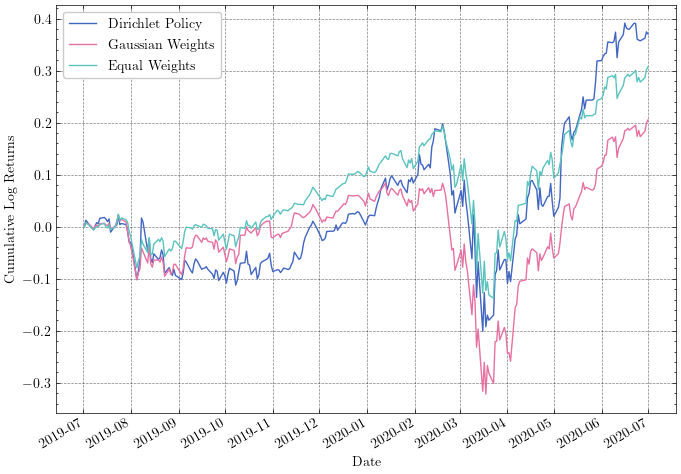

In [149]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# plt.figure(figsize=(8, 6), dpi=100)

ax.plot(dh.test_dates, np.cumsum(dh.historical_policy_returns), label='Dirichlet Policy')
ax.plot(gh.test_dates, np.cumsum(gh.historical_policy_returns), label='Gaussian Weights')
ax.plot(gh.test_dates, np.cumsum(gh.historical_eq_weight_returns), label='Equal Weights')

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.


# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

plt.ylabel('Cumulative Log Returns')
plt.xlabel('Date')
# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.legend()

plt.savefig('unstable_env_10')

In [136]:
gp.θ_μ

array([-0.97747467,  7.33844096, -0.91807032, -2.92195443, -1.52992364,
        1.29583054,  0.31795104,  0.03514964, -0.30256388,  5.39599213,
       -7.16272515,  2.57508456, 11.97452811, -1.9501743 ,  1.05003888,
       -0.48726075, -6.44526488, -4.40277025,  4.00240623, -2.27505756,
        1.88449823,  8.905616  ,  9.79545424,  3.0971793 , -6.93353504])

In [133]:
dp.act(dp.calc_an())

array([[1.88639940e-06, 6.39393972e-02, 6.66791759e-05, 6.15747915e-05,
        1.01043388e-06, 1.30744487e-05, 1.05497213e-03, 3.26130913e-05,
        1.32615545e-01, 5.29288290e-02, 9.38940501e-03, 8.52766152e-08,
        2.64897613e-01, 4.23542670e-02, 2.13863772e-04, 4.49767432e-09,
        1.97296594e-04, 2.44550301e-07, 1.52432314e-05, 3.11176009e-04,
        1.44862484e-01, 4.21912137e-02, 4.89548555e-02, 1.81288836e-01,
        1.46078310e-02]])

In [128]:
market1.returns_df.columns

Index(['NTES', 'BIDU', 'QCOM', 'AVGO', 'MRVL', 'CMCSA', 'MELI', 'TMUS', 'LULU',
       'VRSN', 'XEL', 'CERN', 'SBUX', 'VRSK', 'VRTX', 'GOOGL', 'CTSH', 'CSX',
       'ADSK', 'MTCH', 'MSFT', 'SWKS', 'MRNA', 'CDNS', 'AMD'],
      dtype='object')

In [131]:
market1.returns_df.columns

Index(['ROST', 'NVDA', 'KLAC', 'LRCX', 'SGEN', 'XLNX', 'VRSN', 'ADI', 'MRVL',
       'TEAM', 'MAR', 'AMGN', 'MELI', 'GOOG', 'NXPI', 'BIDU', 'FISV', 'ISRG',
       'SIRI', 'EA', 'MTCH', 'PYPL', 'AMD', 'INTU', 'INCY'],
      dtype='object')

In [141]:
market1.returns_df.columns

Index(['OKTA', 'MNST', 'AMD', 'TMUS', 'MCHP', 'ROST', 'CDW', 'CPRT', 'CHTR',
       'MU', 'LULU', 'AEP', 'ALXN', 'QCOM', 'KHC', 'AVGO', 'TEAM', 'NVDA',
       'VRTX', 'KLAC', 'TCOM', 'CHKP', 'MAR', 'AMZN', 'ADBE'],
      dtype='object')

In [144]:
market1.returns_df.columns


Index(['GOOGL', 'PAYX', 'BIIB', 'TXN', 'REGN', 'CTSH', 'WBA', 'ANSS', 'ILMN',
       'MSFT', 'AMD', 'MELI', 'MDLZ', 'EXC', 'FB', 'VRTX', 'ADSK', 'INTC',
       'DXCM', 'ALXN', 'SWKS', 'ADI', 'PEP', 'DLTR', 'ROST'],
      dtype='object')

In [147]:
market1.returns_df.columns


Index(['TSLA', 'ADP', 'MELI', 'ISRG', 'AAPL', 'CSX', 'DXCM', 'COST', 'LULU',
       'OKTA', 'PCAR', 'KLAC', 'XLNX', 'TCOM', 'AMD', 'SIRI', 'CTSH', 'FISV',
       'FAST', 'CHTR', 'ROST', 'ALGN', 'GILD', 'CERN', 'NFLX'],
      dtype='object')

In [759]:
assets = "['ADP', 'WDAY', 'MXIM', 'TEAM', 'EA', 'NXPI', 'CDNS', 'OKTA', 'MRNA',       'AAPL', 'AMGN', 'CDW', 'AVGO', 'PAYX', 'AEP', 'SNPS', 'ROST', 'NVDA',       'DXCM', 'INTU', 'MRVL', 'MDLZ', 'VRSN', 'CSCO', 'KDP']"

In [760]:
assets.replace('\'', '')

'[ADP, WDAY, MXIM, TEAM, EA, NXPI, CDNS, OKTA, MRNA,       AAPL, AMGN, CDW, AVGO, PAYX, AEP, SNPS, ROST, NVDA,       DXCM, INTU, MRVL, MDLZ, VRSN, CSCO, KDP]'

# Stable environment - Differential Sharpe Ratio

In [25]:
random.shuffle(stocks)
sampled_stocks_10 = stocks[:25]

dparams = {
    'n_assets': len(sampled_stocks_10),
    'α': 0.1,
    'α_end': 0.1,
    'start_ep': 400000, 
    'α_decay_steps': 400000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 4000
}

gparams = {
    'n_assets': len(sampled_stocks_10),
    'α_μ': 0.001,
    'α_σ': 1e-9,
    'γ': 0.1,
    'eps': 1000
}


factory = MarketFactory(sampled_stocks_10, "2017-01-01", "2019-01-01", type='historical')
market1 = factory.create_market()

market2 = factory.create_market()

gp = GaussianPolicy(*list(gparams.values())[:-1])
gh = HistoricalGaussianHarness(market1, gp, reward_mode='dsr')

dp = DirichletPolicyVec(*list(dparams.values())[:-1])
dh = HistoricalHarnessVec(market2, dp, reward_mode='dsr')


for i in range(12):
    
    gp.reset()
    gh.train(num_episodes=dparams['eps'])
    gh.historical_test()
    
    dp.reset()
    dh.train(num_episodes=gparams['eps'])
    dh.historical_test()

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed


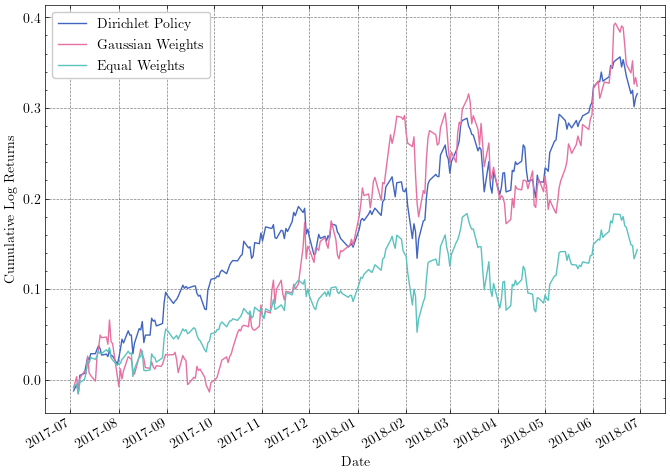

In [26]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# plt.figure(figsize=(8, 6), dpi=100)

ax.plot(dh.test_dates, np.cumsum(dh.historical_policy_returns), label='Dirichlet Policy')
ax.plot(gh.test_dates, np.cumsum(gh.historical_policy_returns), label='Gaussian Weights')
ax.plot(gh.test_dates, np.cumsum(gh.historical_eq_weight_returns), label='Equal Weights')

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.


# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

plt.ylabel('Cumulative Log Returns')
plt.xlabel('Date')
# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.legend()

plt.savefig('dsr_stable_env_16')

# Unstable environment - Differential Sharpe Ratio

In [ ]:
random.shuffle(stocks)
sampled_stocks_10 = stocks[:25]

dparams = {
    'n_assets': len(sampled_stocks_10),
    'α': 0.1,
    'α_end': 0.1,
    'start_ep': 400000, 
    'α_decay_steps': 400000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 8000
}

gparams = {
    'n_assets': len(sampled_stocks_10),
    'α_μ': 0.001,
    'α_σ': 1e-9,
    'γ': 0.1,
    'eps': 2000
}


factory = MarketFactory(sampled_stocks_10, "2019-01-01", "2021-01-01", type='historical')
market1 = factory.create_market()

market2 = factory.create_market()

gp = GaussianPolicy(*list(gparams.values())[:-1])
gh = HistoricalGaussianHarness(market1, gp, reward_mode='dsr')

dp = DirichletPolicyVec(*list(dparams.values())[:-1])
dh = HistoricalHarnessVec(market2, dp, reward_mode='dsr')


for i in range(12):
    
    gp.reset()
    gh.train(num_episodes=dparams['eps'])
    gh.historical_test()
    
    dp.reset()
    dh.train(num_episodes=gparams['eps'])
    dh.historical_test()

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# plt.figure(figsize=(8, 6), dpi=100)

ax.plot(dh.test_dates, np.cumsum(dh.historical_policy_returns), label='Dirichlet Policy')
ax.plot(gh.test_dates, np.cumsum(gh.historical_policy_returns), label='Gaussian Weights')
ax.plot(gh.test_dates, np.cumsum(gh.historical_eq_weight_returns), label='Equal Weights')

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.


# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

plt.ylabel('Cumulative Log Returns')
plt.xlabel('Date')
# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

ax.legend()

plt.savefig('dsr_unstable_env_9')

In [169]:
dp.act(dp.calc_an())

array([[7.13947728e-07, 9.77740364e-09, 3.99853891e-25, 1.77987305e-01,
        6.61972793e-18, 2.85517965e-14, 7.61689361e-07, 1.63916195e-03,
        1.89316172e-01, 2.44230260e-02, 4.77606832e-02, 1.08055161e-01,
        1.09560186e-02, 1.55967988e-02, 2.28772229e-03, 1.94895972e-02,
        8.52400742e-08, 3.33969804e-01, 4.45500525e-02, 1.40805417e-07,
        3.80334040e-06, 1.94076010e-08, 4.79244781e-11, 2.39629630e-02,
        4.20684316e-10]])

In [215]:
np.mean(np.exp(dh.historical_policy_returns))/np.std(dh.historical_policy_returns)

67.41861064162427

In [216]:
np.mean(np.exp(gh.historical_policy_returns))/np.std(gh.historical_policy_returns)

70.18085748977049

In [63]:
market1.returns_df.columns

Index(['XLNX', 'MDLZ', 'LULU', 'AMD', 'ADSK', 'CTAS', 'NVDA', 'KHC', 'MU',
       'MELI', 'CSCO', 'TSLA', 'MSFT', 'CDW', 'TXN', 'AAPL', 'ADBE', 'CMCSA',
       'ADI', 'AMAT', 'NTES', 'VRTX', 'MRNA', 'TCOM', 'SGEN'],
      dtype='object')

In [60]:
# 7
market1.returns_df.columns

Index(['ISRG', 'AMAT', 'ILMN', 'KLAC', 'SIRI', 'XLNX', 'DXCM', 'EA', 'COST',
       'VRSN', 'LULU', 'KDP', 'TMUS', 'CTSH', 'MCHP', 'AEP', 'AMZN', 'LRCX',
       'CDNS', 'ALXN', 'FISV', 'WDAY', 'CMCSA', 'SBUX', 'PAYX'],
      dtype='object')

In [183]:
# 8
market1.returns_df.columns

Index(['SPLK', 'KHC', 'CHTR', 'ADSK', 'ADBE', 'BIIB', 'EBAY', 'PAYX', 'AVGO',
       'MRNA', 'ASML', 'NFLX', 'PDD', 'AMZN', 'VRSK', 'NTES', 'XEL', 'WBA',
       'ISRG', 'INTU', 'ROST', 'WDAY', 'KLAC', 'GILD', 'QCOM'],
      dtype='object')

In [189]:
# 9
market1.returns_df.columns

Index(['MXIM', 'CMCSA', 'CSX', 'ADBE', 'KDP', 'MAR', 'ILMN', 'EBAY', 'CDW',
       'ROST', 'FISV', 'AMAT', 'XLNX', 'GOOGL', 'TXN', 'EA', 'CERN', 'JD',
       'SWKS', 'PEP', 'MSFT', 'AEP', 'ISRG', 'VRTX', 'WBA'],
      dtype='object')

In [696]:
assets = "['PCAR', 'WBA', 'SPLK', 'ADBE', 'INTU', 'FAST', 'KLAC', 'VRTX', 'EBAY',       'AMGN', 'MDLZ', 'TXN', 'FISV', 'ADSK', 'KDP', 'CHTR', 'CDW', 'SIRI',       'AAPL', 'ASML', 'CMCSA', 'OKTA', 'GOOGL', 'NVDA', 'NFLX']"

In [691]:
assets.replace('\'', '')

'[PCAR, WBA, SPLK, ADBE, INTU, FAST, KLAC, VRTX, EBAY,       AMGN, MDLZ, TXN, FISV, ADSK, KDP, CHTR, CDW, SIRI,       AAPL, ASML, CMCSA, OKTA, GOOGL, NVDA, NFLX]'